In [1]:
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=5)

fatal: destination path 'nlp-with-transformers' already exists and is not an empty directory.
/home/jj/github/NLP/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.30.2


/home/jj/anaconda3/envs/deep/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using datasets v2.13.1
Using accelerate v0.20.3
Using sentencepiece v0.1.99


모델이 일련의 로짓을 출력하고 최댓값을 선택해 예측 클래스를 얻는다.  
또는 소프트맥스 함수를 적용해 클래스별 예측 확률을 얻는다.  
### 모델의 확률 출력을 텍스트로 변환하려면 decoding 방법이 필요하다.  

디코딩은 반복적으로 수행되므로 입력이 모델의 정방향 패스를 한 번 통과할 때보다 많은 계산이 필요하다.  
생성된 텍스트의 품질과 다양성은 디코딩 방법과 이에 관련된 하이퍼파라미터에 따라 달라진다.

다른 자기회귀 모델(autogressive model) 또는 코잘 언어 모델(causal language model)과 마찬가지로, gpt-2는 시작 프롬프트 또는 문맥 시퀀스 x = x1, x2, ..., xk가 주어질 때 텍스트에 등장하는 토큰 시퀀스 y = y1, y2, ..., yt의 확률 P(y|x)를 추정하도록 사전 훈련된다.

# 5.2 그리디 서치 디코딩
연속적인 모델 출력에서 이산적인 토큰을 얻는 가장 간단한 디코딩 방법은 각 타임스텝에서 확률이 가장 높은 토큰을 greedy 하게 선택하는 것이다.

#### 그리디 서치 방법을 알아보기 위해 언어 모델링 헤더를 가진 GPT-2 버전을 로드한다.

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
# model_name = "gpt2-xl"
model_name = "gpt2" # 시스템 메모리가 부족하면 작은 버전의 gpt-2 사용
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [3]:
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

#### 이제 텍스트를 생성해보자.
트랜스포머스는 GPT-2 같은 자기회귀 모델을 위해 generate() 함수를 제공하지만, 작동 방식을 이해하기 위해 직접 이 디코딩 메서드를 구현해보자.

'Transformers are the'를 입력 프롬프트로 사용하고 여덟 번의 타임스텝 동안 디코딩 수행  
-> 각 타임스텝에서 프롬프트의 마지막 토큰에 대한 로짓을 선택하고 소프트맥스를 적용해 확률 분포를 얻는다.  
그다음 확률이 가장 높은 토큰을 다음 토큰으로 선택하고 입력 시퀀스에 추가한 뒤 이 과정을 다시 반복한다.

In [4]:
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

In [5]:
input_ids # input_ids[0]은 전체 문장, input_ids[1~3]은 토큰 임베딩

tensor([[41762,   364,   389,   262]], device='cuda:0')

<argsort>  
a = torch.randn(4, 4) <br/>
a <br/>
tensor([[ 0.0785,  1.5267, -0.8521,  0.4065], <br/>
    [ 0.1598,  0.0788, -0.0745, -1.2700], <br/>
    [ 1.2208,  1.0722, -0.7064,  1.2564], <br/>
    [ 0.0669, -0.2318, -0.8229, -0.9280]]) <br/>
<br/>  
<br/>
torch.argsort(a, dim=1) <br/>
tensor([[2, 0, 3, 1], <br/>
        [3, 2, 1, 0], <br/>
        [2, 1, 0, 3], <br/> 
        [3, 2, 1, 0]])

In [6]:
with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0]) # Input에는 전체 문장을 삽입
        output = model(input_ids=input_ids)
        # 첫 번째 배치의 마지막 토큰의 로짓을 선택해 소프트맥스를 적용한다.
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        # 가장 높은 확률의 토큰 index를 내림차순으로 정렬
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        print(sorted_ids)
        # 가장 높은 확률의 토큰을 저장합니다. (정렬했으니 가장 앞의 인덱스에 있음 ㅇㅇ)
        for choice_idx in range(choices_per_step): # 0~4번 즉, 1~5위 순서로 선택
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice # 이 iteration은 사전임
        # 예측한 다음 토큰을 입력에 추가한다.
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)            

tensor([  749,   976,   691,  ...,   208,   179, 37574], device='cuda:0')
tensor([ 2219,  3665,  1593,  ...,   218, 39906, 14827], device='cuda:0')
tensor([ 2099,  3858,  1296,  ..., 36173, 15272, 18945], device='cuda:0')
tensor([  286,   287,    13,  ..., 31204, 14341, 40242], device='cuda:0')
tensor([18758,  2134,  1657,  ..., 31204,  5808, 18945], device='cuda:0')
tensor([   13,   287,   326,  ..., 43491, 37541, 31204], device='cuda:0')
tensor([ 1119,   198,   383,  ..., 33434, 24973, 13945], device='cuda:0')
tensor([  389,   423,   460,  ..., 31573, 17629, 14341], device='cuda:0')


In [7]:
pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (9.76%),same (2.94%),only (2.87%),best (2.38%),first (1.77%)
1,Transformers are the most,common (22.90%),powerful (6.88%),important (6.32%),popular (3.95%),commonly (2.14%)
2,Transformers are the most common,type (15.06%),types (3.31%),form (1.91%),way (1.89%),and (1.49%)
3,Transformers are the most common type,of (83.13%),in (3.16%),. (1.92%),", (1.63%)",for (0.88%)
4,Transformers are the most common type of,particle (1.55%),object (1.02%),light (0.71%),energy (0.67%),objects (0.66%)
5,Transformers are the most common type of particle,. (14.26%),in (11.57%),that (10.19%),", (9.57%)",accelerator (5.81%)
6,Transformers are the most common type of parti...,They (17.48%),\n (15.19%),The (7.06%),These (3.09%),In (3.07%)
7,Transformers are the most common type of parti...,are (38.78%),have (8.14%),can (7.98%),'re (5.04%),consist (1.57%)


In [8]:
iterations

[{'Input': 'Transformers are the',
  'Choice 1': ' most (9.76%)',
  'Choice 2': ' same (2.94%)',
  'Choice 3': ' only (2.87%)',
  'Choice 4': ' best (2.38%)',
  'Choice 5': ' first (1.77%)'},
 {'Input': 'Transformers are the most',
  'Choice 1': ' common (22.90%)',
  'Choice 2': ' powerful (6.88%)',
  'Choice 3': ' important (6.32%)',
  'Choice 4': ' popular (3.95%)',
  'Choice 5': ' commonly (2.14%)'},
 {'Input': 'Transformers are the most common',
  'Choice 1': ' type (15.06%)',
  'Choice 2': ' types (3.31%)',
  'Choice 3': ' form (1.91%)',
  'Choice 4': ' way (1.89%)',
  'Choice 5': ' and (1.49%)'},
 {'Input': 'Transformers are the most common type',
  'Choice 1': ' of (83.13%)',
  'Choice 2': ' in (3.16%)',
  'Choice 3': '. (1.92%)',
  'Choice 4': ', (1.63%)',
  'Choice 5': ' for (0.88%)'},
 {'Input': 'Transformers are the most common type of',
  'Choice 1': ' particle (1.55%)',
  'Choice 2': ' object (1.02%)',
  'Choice 3': ' light (0.71%)',
  'Choice 4': ' energy (0.67%)',
  'Cho

#### 더 복잡한 디코딩 방법을 알아보기 위해 트랜스포머스에 내장된 generate() 함수를 사용해보자.  
앞선 결과를 재현하기 위해 샘플링을 끄고(체크포인트에서 로딩한 모델 설정에 따로 지정되지 않았다면 default가 False다.)  
생성 토큰의 개수를 max_new_tokens 매개변수로 지정한다.

In [9]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens = n_steps, do_sample = False)
print(tokenizer.decode(output[0]))

Transformers are the most common type of particle. They are


#### 조금 더 재밌는 시도 (OpenAI의 유니콘 기사를 재현해보기)
앞에서처럼 토크나이저로 프롬프트를 인코딩하고 긴 텍스트 시퀀스를 생성하기 위해 max_length에 큰 값을 지정한다.

In [10]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n"""

In [11]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length = max_length,
                              do_sample = False)
print(tokenizer.decode(output_greedy[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


"The unicorns were very intelligent, and they were very intelligent," said Dr.
David S. Siegel, a professor of anthropology at the University of California,
Berkeley. "They were very intelligent, and they were very intelligent, and they
were very intelligent, and they were very intelligent, and they were very
intelligent, and they were very intelligent, and they were very intelligent, and
they were very


Greedy Search Decoding의 주요 단점중 하나는  
그리디 서치 알고리즘이 반복적인 출력 시퀀스를 생성하는 경향이 있어서 뉴스기사로는 적절하지 않다는 점이다.  
이는 그리디 서치 알고리즘의 보편적인 문제이며, 이로 인해 최적의 솔루션을 만들어내기 어렵다.  
디코딩 측면에서 보면, 확률이 높은 단어가 확률이 낮은 단어보다 먼저 등장하기 때문에  
전체적인 측면에서 확률이 높은 단어 시퀀스를 생성하지 못하기도 한다.

※ 그리디 서치 디코딩은 다양성이 필요한 텍스트 생성 작업에는 거의 사용되지 않으나, 결정적이고 사실적으로 정확한 출력이 필요한 수식 등의 짧은 문장 생성에는 유용하다.  
이런 작업을 위해 줄바꿈이 있는 "5 + 8 => 13 \n 7 + 2 => 9 \n 1 + 0 =>" 같은 형식의 입력 프롬프트를 제공해 GPT-2의 조건부 생성을 제어할 수 있다.

#### 다행히 더 나은 방법이 존재한다. -> 빔 서치 디코딩(Beam Search Decoding)

# 5.3 빔 서치 디코딩(Beam Search Decoding)

joint probability와 conditional probability에 로그를 씌우면 로그의 곱셈규칙에 따라 확률의 곱셈이 로그 확률의 덧셈으로 바뀐다.  
이러한 방식은 underflow로 인한 수치적 불안정을 일으킬 확률이 낮다.  
그리고 더 작은 수에도 적용 된다.  
(모든 가능성 있는 시퀀스의 확률들 중 b개를 선택하므로)상대적 확률만 비교하면 되므로 로그 확률을 사용해서도 비교가 가능하다.

In [12]:
0.5 ** 1024

5.562684646268003e-309

In [13]:
import numpy as np
sum([np.log(0.5)] * 1024)

-709.7827128933695

#### 그리디 서치와 빔 서치로 생성한 텍스트의 로그 확률을 계산하여 빔 서치가 전체 확률을 향상하는지 확인해보자.
트랜스포머스 모델은 입력 토큰이 주어지면 다음 토큰에 대한 정규화되지 않은 로짓을 반환한다.  
따라서 먼저 로짓을 정규화해서 시퀀스의 각 토큰을 위해 전체 어휘사전에 대한 확률 분포를 만든다.  
그다음 시퀀스에 있는 토큰 확률만 선택한다.  
이 단계를 구현한 함수는 아래와 같다.

In [14]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)

    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1) # squeeze는 차원이 1인거 1개 없애는거 unsqueeze는 만드는거.
    return logp_label

위의 함수는 하나의 토큰에 대한 로그 확률을 제공하므로, 시퀀스의 전체 로그 확률을 얻으려면 각 토큰의 로그 확률을 더한다.

In [15]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

모델이 입력 시퀀스를 생성하지 않았으므로 입력 시퀀스의 로그 확률은 무시한다.  
또 로짓과 레이블의 정렬이 중요하다.  
모델은 다음 토큰을 예측하기 때문에 첫 번째 레이블에 대한 로짓을 얻지 못한다.  
또 마지막 로짓에 대한 정답이 없기 때문에 마지막 로짓은 필요하지 않다.

#### 이 함수를 사용해 OpenAI 프롬프트에서 그리디 서치로 만든 시퀀스의 로그 확률을 계산해보자.

In [16]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


"The unicorns were very intelligent, and they were very intelligent," said Dr.
David S. Siegel, a professor of anthropology at the University of California,
Berkeley. "They were very intelligent, and they were very intelligent, and they
were very intelligent, and they were very intelligent, and they were very
intelligent, and they were very intelligent, and they were very intelligent, and
they were very

로그 확률: -84.91


# -----------------------------------------------------------------------

In [17]:
input_ids

tensor([[  818,   257, 14702,  4917,    11, 11444,  5071,   257, 27638,   286,
         28000, 19942,  2877,   287,   257,  6569,    11,  4271, 31286,  1850,
         19272,    11,   287,   262,   843,   274, 21124,    13,  3412,   517,
          6452,   284,   262,  4837,   373,   262,  1109,   326,   262, 28000,
         19942,  5158,  2818,  3594,    13,   628]], device='cuda:0')

In [18]:
print(input_ids[0])
print(len(input_ids[0]))

tensor([  818,   257, 14702,  4917,    11, 11444,  5071,   257, 27638,   286,
        28000, 19942,  2877,   287,   257,  6569,    11,  4271, 31286,  1850,
        19272,    11,   287,   262,   843,   274, 21124,    13,  3412,   517,
         6452,   284,   262,  4837,   373,   262,  1109,   326,   262, 28000,
        19942,  5158,  2818,  3594,    13,   628], device='cuda:0')
46


In [19]:
len(output_greedy[0])

128

In [20]:
output_greedy

tensor([[  818,   257, 14702,  4917,    11, 11444,  5071,   257, 27638,   286,
         28000, 19942,  2877,   287,   257,  6569,    11,  4271, 31286,  1850,
         19272,    11,   287,   262,   843,   274, 21124,    13,  3412,   517,
          6452,   284,   262,  4837,   373,   262,  1109,   326,   262, 28000,
         19942,  5158,  2818,  3594,    13,   628,   198,     1,   464, 28000,
         19942,   547,   845, 12661,    11,   290,   484,   547,   845, 12661,
           553,   531,  1583,    13,  3271,   311,    13,   311, 28210,    11,
           257,  6240,   286, 45424,   379,   262,  2059,   286,  3442,    11,
         14727,    13,   366,  2990,   547,   845, 12661,    11,   290,   484,
           547,   845, 12661,    11,   290,   484,   547,   845, 12661,    11,
           290,   484,   547,   845, 12661,    11,   290,   484,   547,   845,
         12661,    11,   290,   484,   547,   845, 12661,    11,   290,   484,
           547,   845, 12661,    11,   290,   484,  

# -----------------------------------------------------------------------

#### 이번에는 빔 서치로 생성한 시퀀스와 비교해보자

generate() 함수에서 빔 서치를 활성화하려면 num_beams 매개 변수에 빔 개수를 지정한다.  
빔 크기가 클수록 결과가 더 좋은 가능성이 높다.  
하지만 각 빔에 대해 병렬적으로 시퀀스를 생성하므로 생성 과정이 훨씬 느려진다.

In [24]:
output_beam = model.generate(input_ids, max_length = max_length, num_beams=5,
                            do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, San Diego, and the
University of California, Santa Cruz, found that the unicorns were able to
communicate with each other in a way that was similar to that of human speech.


"The unicorns were able to communicate with each other in a way that was similar
to that of human speech," said study co-lead author Dr. David J.

로그 확률: -80.00


### 단순한 그리디 서치보다 빔 서치에서 더 높은 로그 확률을 얻었다.(높을수록 좋음)
그러나 빔 서치도 텍스트가 반복되는 문제를 보여준다.  
이 문제를 해결하기 위해 no_repeat_ngram_size 매개변수로 n-gram penalty를 부과하는 방법이 있다.  
그러면 지금까지 n-gram을 추적해 이전에 보았던 n-gram을 생성하는 경우 다음 토큰 확률이 0이 된다.

In [25]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                            do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, San Diego, and the National
Science Foundation (NSF) in Boulder, Colorado, were able to translate the words
of the unicorn into English, which they then translated into Spanish.

"This is the first time that we have translated a language into an English
language," said study co-author and NSF professor of linguistics and
evolutionary biology Dr.

로그 확률: -103.54


반복적인 텍스트 생성을 막고 점수는 더 낮아졌지만 텍스트가 일관성을 유지한다.  
#### n-gram penalty를 사용한 빔 서치는 확률이 높은 토큰에 초점을 맞추는 빔 서치와 반복을 줄이는 n-gram penalty의 균형을 잡는 좋은 방법이다.  
#### 사실적인 정확성을 요구하는 요약, 기계 번역 같은 애플리케이션에 널리 사용된다.  
또 분야에 국한되지 않는 잡담이나 기사처럼 사실적인 정확성이 다양성보다 덜 중요할 때, 샘플링을 사용해 다양성을 늘리면서 반복을 줄이는 방법도 있다.

# 5.4 샘플링 방법

샘플링에서 소프트맥스 함수를 적용하기 전 로짓의 스케일을 조정하는 온도 파라미터 T를 추가하면 출력의 다양성의 쉽게 제어된다.

T값을 바꾸면 확률 분포의 형태가 제어된다.  
T < 1일 때 이 분포는 원점 근처에서 정점에 도달하고 드문 토큰을 억제한다.  
반면 T > 1일 때 분포가 평평해지고 각 토큰의 확률이 동일해진다.

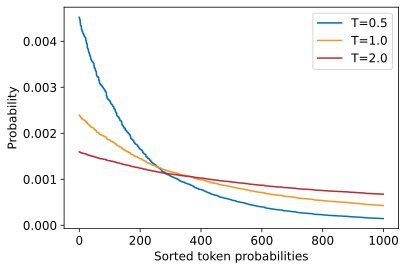

In [29]:
# 세 개의 온도에서 랜덤하게 생성한 토큰 확률의 분포
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1] # step에 -1을 쓰면 요소들을 역순으로 반환
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

온도 T가 생성되는 텍스트에 어떤 영향을 미치는지 알아보기 위해 generate() 함수의 temperature 매개변수를 T=2로 지정해 샘플링을 해보자(top_k 매개변수의 의미는 5.5에서 설명함)

In [32]:
torch.manual_seed(42);

In [33]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                            temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Situmed aren't spiritual novelty chew nostalgiates budsrom Speech spreading
immune deficient laugh Agreement Scroll irrational Nation accomplish Continent
seaf A toast Turner divided California WILL declare mere crime brilliant 131
class inequariansiamond disse * Photographer awards high Mr forearm secured
conference stink zo boxer bees Zika deflation press Vatican credentials
Wrestling chargesThings does Guillard Ty physician Hidden Kimville lost Scotland
Nations at affown temporou MD sociology Canada famously weary


In [34]:
torch.manual_seed(42);

In [35]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                            temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


"We found that the unicorns are not the only ones who speak English," said lead
author Dr. David J. A. Turner, who led the study. "We are also finding that the
unicorns are also speaking different languages. We have found that the unicorns
are also speaking different languages. We are also finding that the unicorns are
also speaking different languages."


The study was published


온도가 낮으면 일관성 있는 텍스트를 생성한다.  
#### 온도는 샘플의 품질을 제어하지만 항상 일관성(낮은 온도)과 다양성 (높은 온도)의 균형점이 있기 때문에 당면한 문제에 따라 조정해야 한다.

#### 일관성과 다양성의 균형을 조정하는 또 다른 방법으로 어휘사전의 분포를 잘라내는 방법이 있다.
이 방법은 온도와 함께 다양성을 자유롭게 조정하지만, 더 제한된 범위에서 문맥상 매우 이상한 단어(즉, 확률이 낮은 단어)를 제외한다.  
대표적인 방법은 top-k sampling과 뉴클리어스 샘플링 (= nucleus sampling = top-p sampling)이다.

# 5.5 탑-k 및 뉴클리어스 샘플링

탑-k와 뉴클리어스(탑-p) 샘플링 모두 각 타임스텝에서 샘플링에 사용할 토큰의 개수를 줄인다는 개념에 기초한다.

#### T=1에서 모델이 출력하는 다음 토큰 예측의 확률 분포 및 누적 확률 분포를 시각화

In [36]:
torch.manual_seed(42);

In [37]:
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [56]:
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    print(output.logits)
    print(output.logits.size())
    print("아웃풋로짓---------------------------------------------------------------------------------------------------------------")
    next_token_logits = output.logits[:, -1, :]
    print(next_token_logits)
    print("다음토큰로짓---------------------------------------------------------------------------------------------------------------")
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy() # detach는 gradient 연산에 사용되지 않는(backpropagation이 안되도록 하는) 텐서 생성
    print(probs)

tensor([[[ -31.9929,  -31.0130,  -33.8790,  ...,  -38.3651,  -38.3280,
           -31.4818],
         [-102.1611, -100.8095, -103.2901,  ..., -108.3615, -105.8933,
           -98.8553],
         [ -96.9154,  -94.5693,  -99.7803,  ..., -104.4286, -106.4145,
           -97.5659],
         ...,
         [-114.0623, -112.5745, -116.3503,  ..., -126.6086, -126.5277,
          -106.7796],
         [-267.2537, -264.1407, -270.0345,  ..., -291.0894, -297.2594,
          -264.0369],
         [-104.2208,  -93.2703,  -99.9104,  ..., -119.7041, -120.1617,
          -107.0007]]], device='cuda:0')
torch.Size([1, 47, 50257])
아웃풋로짓---------------------------------------------------------------------------
------------------------------------
tensor([[-104.2208,  -93.2703,  -99.9104,  ..., -119.7041, -120.1617,
         -107.0007]], device='cuda:0')
다음토큰로짓--------------------------------------------------------------------------
-------------------------------------
[[3.5952039e-06 2.0487016e-01 2.6773

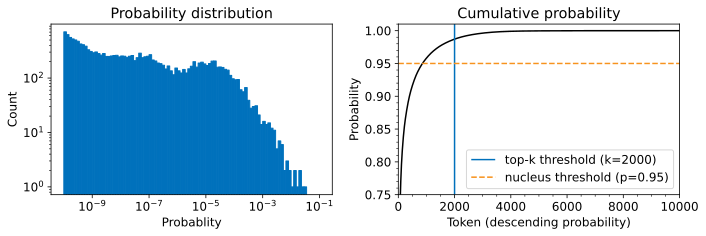

In [58]:
# 다음 토큰 예측의 확률 분포(왼쪽)과 내림차순으로 정렬된 토큰 확률의 누적분포
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

# bins 는 히스토그램으로 표현될 변수의 전체 범위를 몇개의 막대로 표현할지
# linspace : 설정한 범위에서 선형적으로 분할한 위치의 값을 출력합니다. 
# logspace : 설정한 범위에서 로그로 분할한 위치의 값을 출력합니다. 
# np.logspace(a, b, c) -> log(a) 와 log(b) 사이에 등간격인 c개의 행벡터를 생성
axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probablity")
axes[0].set_ylabel("Count")
# axes[0].grid(which="major")

# np.cumsum은 배열에서 주어진 축에 따라 누적되는 원소들의 누적 합을 계산하는 함수.
# 다시말하지만 [::-1]는 역수로 반환
axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
# axes[1].grid(which="major")
axes[1].minorticks_on() # axes[1] 그림에 보조 눈금 표시 활성화 기능 on
# axes[1].grid(which="major", linewidth='0.5')
top_k_label = "top-k threshold (k=2000)"
top_p_label = 'nucleus threshold (p=0.95)'

# axvline(): 축을 따라 수직선을 표시합니다.
# axhline(): 축을 따라 수평선을 표시합니다.
# vlines(): 지정한 점을 따라 수직선을 표시합니다.
# hlines(): 지정한 점을 따라 수평선을 표시합니다.
axes[1].vlines(x=2000, ymin=0, ymax=2, color="C0", label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color="C1", label=top_p_label, linestyle='--')
axes[1].legend(loc="lower right")
plt.tight_layout()

왼쪽 그래프를 보면 확률이 가장 높은 토큰을 선택할 확률은 1/10 조금 안된다.  

오른쪽 그래프에서 내림차순 확률로 토큰을 정렬한 다음, 처음 10,000개 토큰의 누적 합을 계산했다.  
(GPT-2의 어휘 사전에는 총 50,257개 토큰이 있다.)  
이 곡선은 확률이 높은 토큰 중 하나를 선택할 확률을 나타낸다.  
예를 들어 확률이 가장 높은 1,000개 토큰 중 하나를 선택할 확률은 약 96%다.  
확률이 빠르게 90%를 상회하지만 수천 개의 토큰이 지나야 약 100%에 가깝게 수렴한다.  
그래프를 보면 하위 8,000개 토큰 중 하나를 선택할 확률은 약 1/100 이다.

이 수치는 처음에는 작아보이지만 텍스트를 생성할 때 토큰마다 한 번씩 샘플링 하기 때문에 중요하다.  
겨우 100분의 1 또는 1,000분의 1이더라도, 수백 번 샘플링하게 되면 언젠가 희귀한 토큰을 선택할 가능성이 있다.  
샘플링에서 이런 토큰을 선택하면 생성된 텍스트의 품질이 떨어지기도 한다.  
이런 이유로 확률이 매우 낮은 토큰은 피한다.  
#### 이런 배경에서 탑-k와 탑-p 샘플링이 등장했다.

#### 탑-k 샘플링은 확률이 가장 높은 k개 토큰에서만 샘플링해서 확률이 낮은 토큰을 피한다.  
이렇게 하면 확률 분포의 long tail을 잘라내고 확률이 가장 높은 토큰에서만 샘플링하는 것이 가능해진다.  
#### 탑-k 샘플링은 그림의 수직선을 정의하고 왼쪽에 있는 토큰에서만 샘플링한다.
(수직선 오른쪽은 아무리 더해도 별로 증가하지 않는다는 것을 생각할 것)  
generate() 함수는 이 작업을 쉽게 수행하는 매개변수 top_k를 제공한다.

In [59]:
torch.manual_seed(42);

In [61]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True,
                            top_k=50)
print(tokenizer.decode(output_topk[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists noted that the researchers did not find a single trace of an
unusual combination of common human languages with the sounds described in this
study, but this seems odd in such a remote area.


While the findings from the survey of 20,000 sheep and dogs had shown that no
matter how loud or cold the animal's air was, it will often react at high
altitudes to be in the region


이 텍스트가 지금까지 생성한 결과 중에서 가장 사람이 쓴 글처럼 보인다.  
#### 하지만 k값을 어떻게 정해야 할까?
k값은 수동으로 선택해야 하고 실제 출력 분포에 상관없이 시퀀스의 각 선택에 동일하게 적용된다.  
다음 장에서 살펴볼 몇 가지 텍스트 품질 지표를 사용해 적당한 k 값을 찾아보자.  
하지만 고정된 컷오프cutoff는 만족스럽지 않은 경우도 있다.

이에 대한 대안으로 동적인 컷오프를 적용하는 방법이 있다.  
#### 뉴클리어스 샘플링 또는 탑-p 샘플링에서는 고정된 컷오프 값을 선택하지 않고 어디서 컷오프를 할지 조건을 지정한다.  
이 조건은 선택한 특정 확률 질량 probability mass에 도달할 때다.  
가령 이 값을 95%로 지정했다고 가정해보자.  
그다음 확률에 따라 내림차순으로 모든 토큰을 정렬하고 선택한 토큰의 확률 값이 95%에 도달할 때까지 이 리스트의 맨 위부터 토큰을 하나씩 추가한다.  
#### p값은 누적 확률 그래프의 수평선에 해당한다.
이 수평선의 아래에 있는 토큰에서만 샘플링을 하게 된다.  
출력 분포에 따라 (확률이 매우 높은) 하나의 토큰이 될 수도 있고 (확률이 비슷한) 백 개의 토큰이 될 수도 있다.

이제 generate() 함수가 top_p 샘플링을 위한 매개변수도 제공한다는 것을 알 수 있을 것.

In [62]:
torch.manual_seed(42);

In [63]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True,
                            top_p=0.90)
print(tokenizer.decode(output_topp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists found that the unicorns, called "suspects," speak English better
than human languages, according to a report in the journal Evolution.


In the study, a group of researchers analyzed data from several types of
research into human evolution from prehistoric to present day.


First, they studied how the ancestors of humans differed from the ancestors of
non-human apes. Their results are the


탑-p 샘플링도 일관성 있는 텍스트를 생성한다.  
### 두 샘플링 방법을 연결하면 양쪽의 장점을 모두 취할 수 있다.
### top_k=50 와 top_p=0.9으로 지정하면 확률이 가장 높은 50개 토큰에서 확률 질량이 90%인 토큰을 선택하게 된다.

※ 샘플링할 때 빔 서치를 적용하는 방법도 있다.  
다음 후보 토큰의 배치를 탐욕적으로 선택하지 않고 샘플링을 통해 같은 식으로 빔 세트를 구성하는 방법이다.

## GPT 유형의 모델을 밑바닥부터 훈련하는 방법이 궁금하다면 곧장 10장으로 넘어가도 좋다.

## 10장에서는 대규모 코드 데이터셋을 수집해 자기회귀 언어 모델 autogressive language model을 훈련한다.

In [69]:
torch.cuda.memory_allocated()

535579648

In [70]:
torch.cuda.memory_reserved() 

616562688

In [71]:
torch.cuda.empty_cache() # torch.cuda.empty_cache()는 torch.cuda.memory_reserved() 에서 보이는 만큼을 free하게 해줍니다